# VR Selections

**Goal:** Understand the impact of the selections that we're applying to the VR track jets by making a cutflow for the hybrid sample that Francesco sent me.

One of the VR hybrid files that Francesco sent me has 400k events, but only about 420k jets passing the selections, which seemed kind of low, but this was when I was selecting jets with $p_T$ > 10 GeV.

We want to find *which* of the cuts are causing these VR track jets to fail the selection.

**Table of Contents**
1. Number of constituents
2. Cutflows
3. Input distributions?

In [1]:
import uproot
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import numpy as np
import pandas as pd

import os
import sys
sys.path.append("../..")
from root_to_np import getdR, passJet
from usefulFcts import VR, ftag_cone

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

Using TensorFlow backend.


This variable `physicsSample` dictates which physics sample we want to look at for these cuts, and allows us to repeat these studies and save plots to different subdirectories!

In [2]:
physicsSample = 'Zprime_5TeV'
subDir = 'mc16d_VR_'+physicsSample

In [3]:
physicsNames = {'ttbar': r'$t\bar{t}$ sample',
                'Zprime_1.5TeV': 'standard Z\' sample',
                'Zprime_5TeV': 'extended Z\' sample',
                'hybrid_1.5TeV': 'standard hybrid sample' 
               }

In [4]:
fDir = "../../../public/"

fnames = {
    'ttbar' : 'user.bdong.410470.ttbar_hdamp258p75_nonallhad.mc16d_newDerivation_noRetag_AktVR30Rmax4Rmin02Tr/user.bdong.16276417.AktVR30Rmax4Rmin02Tr._000002.root',
    'Zprime_1.5TeV' : 'user.bdong.mc16_13TeV.427080.flatpT_Zprime.mc16d_newDerivation_noRetag_rerun_AktVR30Rmax4Rmin02Tr/user.bdong.16288899.AktVR30Rmax4Rmin02Tr._000002.root',
    'Zprime_5TeV'   : 'user.bdong.mc16_13TeV.427081.flatpT_Zprime_Extended.mc16d_noRetag_Apr29_AktVR30Rmax4Rmin02Tr/user.bdong.17895253.AktVR30Rmax4Rmin02Tr._000001.root',
    'hybrid_1.5TeV' : "FrancescoNtuples/mc16d_VR_hybrid_1.5TeV/VR_Track_noBug_4RNN_18219_correct_lowerStat_2_const.root"
    }

fname = fDir + fnames[physicsSample]
myTree = uproot.open(fname)["bTag_AntiKtVR30Rmax4Rmin02TrackJets"]

Look at what is inside the TTree. Note, for the hybrid sample, Francesco is only saving a subset of the variables that we needed for the training.

In [5]:
for k in myTree.keys():
    if 'bH' in k.decode():
        print(k)

b'jet_bH_pdgId'
b'jet_bH_parent_pdgId'
b'jet_bH_pt'
b'jet_bH_eta'
b'jet_bH_phi'
b'jet_bH_E'
b'jet_bH_charge'
b'jet_bH_Lxy'
b'jet_bH_x'
b'jet_bH_y'
b'jet_bH_z'
b'jet_bH_dRjet'
b'jet_bH_prod_x'
b'jet_bH_prod_y'
b'jet_bH_prod_z'
b'jet_bH_PtTrk'
b'jet_bH_MTrk'
b'jet_bH_nBtracks'
b'jet_bH_nCtracks'
b'jet_bH_nBtracks_400'
b'jet_bH_nCtracks_400'
b'jet_bH_child_hadron_idx'
b'jet_bH_child_pdg_id'
b'jet_bH_child_parent_pdg_id'
b'jet_bH_child_barcode'
b'jet_bH_child_charge'
b'jet_bH_child_px'
b'jet_bH_child_py'
b'jet_bH_child_pz'
b'jet_bH_child_E'
b'jet_bH_child_prod_x'
b'jet_bH_child_prod_y'
b'jet_bH_child_prod_z'
b'jet_bH_child_decay_x'
b'jet_bH_child_decay_y'
b'jet_bH_child_decay_z'
b'bH1FromParent_pt'
b'bH1FromParent_eta'
b'bH1FromParent_phi'
b'bH1FromParent_Lxy'
b'bH1FromParent_x'
b'bH1FromParent_y'
b'bH1FromParent_z'
b'bH1FromParent_dRjet'
b'bH2FromParent_pt'
b'bH2FromParent_eta'
b'bH2FromParent_phi'
b'bH2FromParent_Lxy'
b'bH2FromParent_x'
b'bH2FromParent_y'
b'bH2FromParent_z'
b'bH2FromPare

In [6]:
np.concatenate(myTree.array(b'jet_dRminToB')[myTree.array(b'jet_dRminToB') != 10],axis=0)

array([0.0124679 , 0.14710379, 0.01634456, ..., 1.3481152 , 1.1656146 ,
       2.2411497 ], dtype=float32)

One of the new cuts for VR track jets was cutting on the number of tracks defining the jet, here taken into account by the [`jet_nConst` variable](https://twiki.cern.ch/twiki/bin/view/AtlasProtected/TrackJetSelectionRecAndGuide). 

In [7]:
figDir = '../../figures/'+subDir

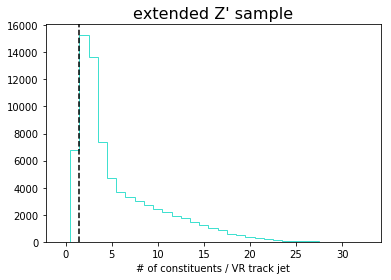

In [8]:
flat_jet_nConst = np.concatenate(myTree.array(b'jet_nConst'),axis=0)
nMax = int(flat_jet_nConst.max())

plt.hist(flat_jet_nConst,bins=nMax+1,range=(-0.5,nMax+0.5),
         histtype='step',color='turquoise')
plt.xlabel('# of constituents / VR track jet')
plt.title(physicsNames[physicsSample], fontsize=16)

ylim = plt.ylim()
plt.plot([1.5,1.5],ylim,'k--')
plt.ylim(ylim)

plt.savefig('{}/nConst_cut.pdf'.format(figDir))
plt.show()

- For $t\bar{t}$, this cut on the number of constitents will get rid of *a lot* of our VR track jets. **This is counter-intuitive to me, because I would have naively thought that the $t\bar{t}$ lower $p_T$ sample would have more low $p_T$ jets, which meant track jets with a higher jet multiplicity?** This could be due to fake tracks, but I don't understand *why* this would be more of an affect for $t\bar{t}$ than Z'? Maybe this is where we're loosing all of these jets in the hybrid selection?
- For Z' ...
- When I aggregate across the hybrid sample, I didn't think this cut was having that much of an effect... but idk.

**Impact of the differnt VR track jet definition and FTAG association cones**

Ok, in the `VR-Key-Ideas` notebook, I overlaid the curves for the radius used to define the VR jet as a function of the jet $p_T$. One of the messages of that plot was that for most jet $p_T$s, the b-tagging track association cone was *looser*, so to verify this, look at the difference between the `jet_nConst` and the `jet_btag_ntrk` variables, and their correlation w/ $p_T$.

Caveat: Francesco didn't save `jet_btag_ntrk` for the hybrid sample.

In [9]:
flat_jet_nConst.max()

32.0

In [10]:
if 'hybrid' not in physicsSample:
    flat_jet_bTagTrks = np.concatenate(myTree.array(b'jet_btag_ntrk'),axis=0)
    flat_jet_bTagTrks.max()

In [11]:
if 'hybrid' not in physicsSample:
    nMax = 50
    plt.hist(flat_jet_nConst, bins=nMax+1, range=(-0.5,nMax+0.5),
             histtype='step', color='turquoise',
             label='defining the VR track jet')
    plt.hist(flat_jet_bTagTrks, bins=nMax+1, range=(-0.5,nMax+0.5),
             histtype='step', color='hotpink',
             label='used by b-tagging')

    plt.xlabel('$n_{trks}$',fontsize=14)
    plt.legend(fontsize=12)
    plt.title(physicsNames[physicsSample], fontsize=16)

    plt.savefig('{}/nConst_nBtagTrks.pdf'.format(figDir))
    plt.show()

Yes, as expected, there are many more tracks for FTAG association. 

In [12]:
# Note: for VR track jets, there's no difference between the calibrated
# and uncalibrated jet pt
flat_jet_pt = np.concatenate(myTree.array(b'jet_pt'),axis=0) * 0.001 # GeV
print('Min jet pt: {}'.format(np.min(flat_jet_pt)))
print('Max jet pt: {}'.format(np.max(flat_jet_pt)))

Min jet pt: 2.0000059604644775
Max jet pt: 392128.15625


In [13]:
flat_jet_flav = np.concatenate(myTree.array(b'jet_LabDr_HadF'),axis=0)

In [14]:
myMin, myMax = np.min(flat_jet_flav),np.max(flat_jet_flav)
nBins = myMax-myMin+1
myRange = (myMin-0.5,myMax+0.5)

plt.hist(flat_jet_flav,bins=nBins,range=myRange)
plt.xlabel('pdg ID')
plt.title(physicsNames[physicsSample], fontsize=16)
plt.savefig('{}/pdgs.pdf'.format(figDir))
plt.show()

- For $t\bar{t}$ and Z', it looks like there are a lot of these track jets that don't have a truth flavor label, so we don't have to worry about why we got such a dramatic cut when we cut on the $p_T$, because if we only considered b,c,l jets, this isn't so much of an issue. 
- For hybrid, it looks like Francesco already skimmed the jets such that we only have b,c, and l jets.

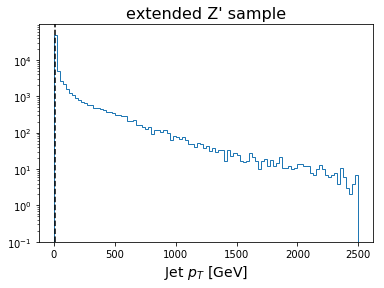

In [15]:
ptmax = {'ttbar':300,
         'Zprime_1.5TeV':1500,
         'Zprime_5TeV':2500,
         'hybrid_1.5TeV':1500}

plt.hist(flat_jet_pt, bins=100, range=[0,ptmax[physicsSample]],
         histtype='step',log=True) 
    
ylim = plt.ylim()
plt.plot([10,10],ylim,'k--')
plt.ylim(ylim)
#plt.yscale('log')

plt.xlabel('Jet $p_T$ [GeV]',fontsize=14)
plt.title(physicsNames[physicsSample], fontsize=16)
plt.savefig('{}/jet_pT_all.pdf'.format(figDir))
plt.show()

In [16]:
for pdg,flav in zip([0,4,5],['l','c','b']):
    plt.hist(flat_jet_pt[flat_jet_flav==pdg],
             bins=100,range=[0,ptmax[physicsSample]],
             histtype='step',label=flav+'-jets',log=True)
                          
ylim = plt.ylim()
plt.plot([10,10],ylim,'k--')
plt.ylim(ylim)
plt.xlabel('Jet $p_T$ [GeV]',fontsize=14)
plt.legend()
plt.title(physicsNames[physicsSample], fontsize=16)
plt.savefig('{}/jet_pT.pdf'.format(figDir))
plt.show()

I still don't understand this plot ;( 

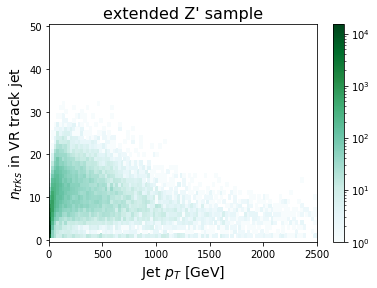

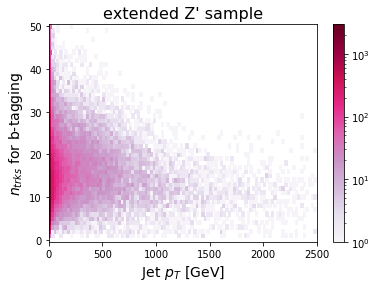

In [17]:
nMax = 50

if 'hybrid' in physicsSample:
    myVars = [flat_jet_nConst]
else:
    myVars = [flat_jet_nConst,flat_jet_bTagTrks]
    
for var, cmap, ylabel, tag in zip(myVars, ['BuGn','PuRd'],
                                  ['in VR track jet','for b-tagging'],
                                  ['nConst','nBtagTrks']):
    
    plt.figure()
    plt.hist2d(flat_jet_pt, var, cmap=cmap, norm=LogNorm(),
               bins=[100,nMax+1],
               range=[[0,ptmax[physicsSample]],[-0.5,nMax+0.5]])
    plt.xlabel('Jet $p_T$ [GeV]',fontsize=14)
    plt.ylabel('$n_{trks}$ '+ylabel,fontsize=14)
    plt.title(physicsNames[physicsSample], fontsize=16)
    plt.colorbar()
    
    plt.savefig('{}/{}_vs_jpt.pdf'.format(figDir,tag))
    plt.show()

Ok, in the $n_{trks}$ for the VR track jet definition, it looks like we have a stripe for jets with only one track, but very high jet $p_T$. This means that the very high unphysical track jet $p_T$ values could be due to fake (combinatorial) tracks which got reconstructed alone as a track jet.

**Event level vars**

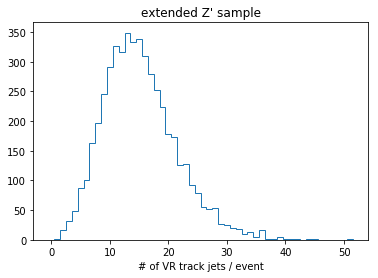

In [18]:
njets = myTree.array(b'njets')

nMax = njets.max()

plt.hist(njets,bins=nMax+1,range=(-0.5,nMax+0.5),
         histtype='step')

plt.xlabel('# of VR track jets / event')
plt.title(physicsNames[physicsSample])
plt.savefig('{}/nJets.pdf'.format(figDir))
plt.show()

I sent this plot for the standard hybrid sample to Francesco, and he said this bump was kind of funny, and he said I should look at this as a function of jet_pt.

In [19]:
njets_perJet = np.concatenate(np.array([[nj]*nj for nj in myTree.array(b'njets')]),axis=0)

In [20]:
plt.hist2d(flat_jet_pt,njets_perJet,
           bins=(100,nMax+1),range=((0,ptmax[physicsSample]),(-0.5,nMax+0.5)),
           norm=LogNorm(),cmap="Blues")
plt.colorbar()
plt.xlabel('Jet $p_T$ [GeV]')
plt.ylabel('# of VR track jets / event')
plt.title(physicsNames[physicsSample])
plt.savefig('{}/nJets_vs_jpt.pdf'.format(figDir))
plt.show()

This number of jets is pretty high, so we want to instead make this plot looking at jets with $p_T > 10$ GeV. I could also make it with everything else applied, but this $p_T$ cut is already by far the most stringent.

In [21]:
cut_pT = 10e3 # MeV

njets_10GeV = np.array([np.sum((pts > cut_pT)) for pts in myTree.array(b'jet_pt')])
myNMax = njets_10GeV.max()

plt.hist(njets_10GeV,bins=myNMax+1,range=(-0.5,myNMax+0.5), histtype='step')

_, xmax = plt.xlim()
_, ymax = plt.ylim()
plt.text(0.45*xmax,0.9*ymax,'VR track jets with $p_T$ > {:.0f} GeV'.format(cut_pT/1000))
plt.xlabel('# of VR track jets / event')
plt.title(physicsNames[physicsSample])
plt.savefig('{}/nJets_{:.0f}GeV.pdf'.format(figDir,cut_pT/1000))
plt.show()

In [22]:
df_file = 'flav_fractions.h5'

if os.path.exists(df_file):
    my_df = pd.read_hdf(df_file, key='df')
    
else:
    index = ['{} fraction'.format(f) for f in ['l','c','b']]
    columns = [r'$t\bar{t}$ sample', 'standard Z\' sample', 'standard hybrid sample']
    my_df = pd.DataFrame(0,index,columns)
    
my_df.round(2)

$t\bar{t}$ sample  standard Z' sample  standard hybrid sample  \
l fraction               0.56                0.71                    0.54   
c fraction               0.07                0.15                    0.11   
b fraction               0.32                0.14                    0.34   

            $t\bar{t}$ sample used in hybrid  \
l fraction                              0.56   
c fraction                              0.07   
b fraction                              0.32   

            standard Z' sample used in hybrid  extended Z' sample  
l fraction                               0.37                0.75  
c fraction                               0.26                0.13  
b fraction                               0.38                0.11

In [23]:
for pdg, flav in zip([0,4,5],['l','c','b']):

    num = np.sum([np.sum((pts > cut_pT) & (np.abs(pdgs) == pdg)) for pts,pdgs in zip(myTree.array(b'jet_pt'),myTree.array(b'jet_LabDr_HadF'))])
    den = np.sum([np.sum((pts > cut_pT)) for pts in myTree.array(b'jet_pt')])

    row = '{} fraction'.format(flav)
    col = physicsNames[physicsSample]

    my_df.loc[row,col] = num / den

In [24]:
print('VR track jet pT > {:.0f} GeV'.format(cut_pT/1000))
my_df.round(2)

VR track jet pT > 10 GeV


$t\bar{t}$ sample  standard Z' sample  standard hybrid sample  \
l fraction               0.56                0.71                    0.54   
c fraction               0.07                0.15                    0.11   
b fraction               0.32                0.14                    0.34   

            $t\bar{t}$ sample used in hybrid  \
l fraction                              0.56   
c fraction                              0.07   
b fraction                              0.32   

            standard Z' sample used in hybrid  extended Z' sample  
l fraction                               0.37                0.75  
c fraction                               0.26                0.13  
b fraction                               0.38                0.11

In [25]:
for pdg, flav in zip([0,4,5],['l','c','b']):

    num = np.sum([np.sum((pts > cut_pT) & (np.abs(pdgs) == pdg)) for pts,pdgs in zip(myTree.array(b'jet_pt'),myTree.array(b'jet_LabDr_HadF'))])
    den = np.sum([np.sum((pts > cut_pT)) for pts in myTree.array(b'jet_pt')])

    row = '{} fraction'.format(flav)
    col = physicsNames[physicsSample]

    my_df.loc[row,col] = num / den

I think I should also look at the flavor fractions when I'm cutting on the track jet $p_T$ that Francesco is using in the hybrid creation script.

In [26]:
hyb_pt_cut = 150e3

if physicsSample == 'ttbar':
    
    col = physicsNames[physicsSample] + ' used in hybrid'
    
    for pdg, flav in zip([0,4,5],['l','c','b']):

        if pdg == 5:
            num = np.sum([np.sum((pts > cut_pT) & (np.abs(pdgs) == pdg) & (np.array([bHs[0] for bHs in bH_pts]) < 250e3)) \
                          for pts,pdgs,bH_pts in zip(myTree.array(b'jet_pt'),
                                                     myTree.array(b'jet_LabDr_HadF'),
                                                     myTree.array(b'jet_bH_pt'))])
            
        else:
            num = np.sum([np.sum((pts > cut_pT) & (np.abs(pdgs) == pdg) & (pts < hyb_pt_cut)) \
                          for pts,pdgs in zip(myTree.array(b'jet_pt'),myTree.array(b'jet_LabDr_HadF'))])
            
        den = np.sum([np.sum((pts > cut_pT) & ( ((pts < hyb_pt_cut) & (np.abs(pdgs) != 5)) | ((np.array([bHs[0] for bHs in bH_pts]) < hyb_pt_cut) & (np.abs(pdgs) == 5))) ) \
                     for pts,pdgs,bH_pts in zip(myTree.array(b'jet_pt'),
                                                myTree.array(b'jet_LabDr_HadF'),
                                                myTree.array(b'jet_bH_pt'))])

        row = '{} fraction'.format(flav)
        
        my_df.loc[row,col] = num / den

In [27]:
if 'Zprime' in physicsSample:
    
    col = physicsNames[physicsSample] + ' used in hybrid'
    
    for pdg, flav in zip([0,4,5],['l','c','b']):

        if pdg == 5:
            num = np.sum([np.sum((pts > cut_pT) & (np.abs(pdgs) == pdg) & (np.array([bHs[0] for bHs in bH_pts]) > 250e3)) \
                          for pts,pdgs,bH_pts in zip(myTree.array(b'jet_pt'),
                                                     myTree.array(b'jet_LabDr_HadF'),
                                                     myTree.array(b'jet_bH_pt'))])
            
        else:
            num = np.sum([np.sum((pts > cut_pT) & (np.abs(pdgs) == pdg) & (pts > hyb_pt_cut)) \
                          for pts,pdgs in zip(myTree.array(b'jet_pt'),myTree.array(b'jet_LabDr_HadF'))])
            
        den = np.sum([np.sum((pts > cut_pT) & ( ((pts > hyb_pt_cut) & (np.abs(pdgs) != 5)) | ((np.array([bHs[0] for bHs in bH_pts]) > hyb_pt_cut) & (np.abs(pdgs) == 5))) ) \
                     for pts,pdgs,bH_pts in zip(myTree.array(b'jet_pt'),
                                                myTree.array(b'jet_LabDr_HadF'),
                                                myTree.array(b'jet_bH_pt'))])

        row = '{} fraction'.format(flav)
        
        my_df.loc[row,col] = num / den

In [28]:
my_df[[r'$t\bar{t}$ sample used in hybrid','standard Z\' sample used in hybrid','standard hybrid sample']].round(2)

$t\bar{t}$ sample used in hybrid  \
l fraction                              0.56   
c fraction                              0.07   
b fraction                              0.32   

            standard Z' sample used in hybrid  standard hybrid sample  
l fraction                               0.37                    0.54  
c fraction                               0.26                    0.11  
b fraction                               0.38                    0.34

In [29]:
my_df[[r'$t\bar{t}$ sample used in hybrid','standard Z\' sample used in hybrid','extended Z\' sample used in hybrid']].round(2)

$t\bar{t}$ sample used in hybrid  \
l fraction                              0.56   
c fraction                              0.07   
b fraction                              0.32   

            standard Z' sample used in hybrid  \
l fraction                               0.37   
c fraction                               0.26   
b fraction                               0.38   

            extended Z' sample used in hybrid  
l fraction                               0.54  
c fraction                               0.22  
b fraction                               0.20

In [30]:
my_df.round(2)

$t\bar{t}$ sample  standard Z' sample  standard hybrid sample  \
l fraction               0.56                0.71                    0.54   
c fraction               0.07                0.15                    0.11   
b fraction               0.32                0.14                    0.34   

            $t\bar{t}$ sample used in hybrid  \
l fraction                              0.56   
c fraction                              0.07   
b fraction                              0.32   

            standard Z' sample used in hybrid  extended Z' sample  \
l fraction                               0.37                0.75   
c fraction                               0.26                0.13   
b fraction                               0.38                0.11   

            extended Z' sample used in hybrid  
l fraction                               0.54  
c fraction                               0.22  
b fraction                               0.20

In [31]:
my_df.columns

Index(['$t\bar{t}$ sample', 'standard Z' sample', 'standard hybrid sample',
       '$t\bar{t}$ sample used in hybrid', 'standard Z' sample used in hybrid',
       'extended Z' sample', 'extended Z' sample used in hybrid'],
      dtype='object')

In [32]:
my_df[[r'$t\bar{t}$ sample']].round(2)

$t\bar{t}$ sample
l fraction               0.56
c fraction               0.07
b fraction               0.32

Ok, so now I'm super confused. For the $b$-tagging discriminant, we're using $f_c$, but clearly this isn't doing what we're thinking now!

$$D_b = \ln \frac{p_b}{ f_c p_c + (1-f_c) p_l}$$

In [33]:
my_df[r'$t\bar{t}$ sample'] / (1-0.32)

l fraction    0.824318
c fraction    0.108451
b fraction    0.471139
Name: $t\bar{t}$ sample, dtype: float64

In [34]:
my_df.to_hdf(df_file,key='df')

In [35]:
np.sum(my_df[col])

0.9661298476204232

Michael also wanted me to look at this metric only taking the two leading jets, but this metric only makes sense for when I'm looking at the Z' sample.

In [36]:
if 'Zprime' in physicsSample:
    
    col = physicsNames[physicsSample] + ' used in hybrid with two leading jets'
    
    for pdg, flav in zip([0,4,5],['l','c','b']):

        if pdg == 5:
            num = np.sum([np.sum((np.abs(pdgs[:2]) == pdg) & (np.array([bHs[0] for bHs in bH_pts])[:2] > 250e3)) \
                          for pts,pdgs,bH_pts in zip(myTree.array(b'jet_pt'),
                                                     myTree.array(b'jet_LabDr_HadF'),
                                                     myTree.array(b'jet_bH_pt'))])
            
        else:
            num = np.sum([np.sum((np.abs(pdgs[:2]) == pdg) & (pts[:2] > hyb_pt_cut)) \
                          for pts,pdgs in zip(myTree.array(b'jet_pt'),myTree.array(b'jet_LabDr_HadF'))])
            
        den = np.sum([np.sum(((pts[:2] > hyb_pt_cut) & (np.abs(pdgs[:2]) != 5)) | ((np.array([bHs[0] for bHs in bH_pts])[:2] > hyb_pt_cut) & (np.abs(pdgs[:2]) == 5)) ) \
                     for pts,pdgs,bH_pts in zip(myTree.array(b'jet_pt'),
                                                myTree.array(b'jet_LabDr_HadF'),
                                                myTree.array(b'jet_bH_pt'))])

        row = '{} fraction'.format(flav)
        
        my_df.loc[row,col] = num / den
        

In [37]:
if physicsSample == 'Zprime_1.5TeV':
    my_df[['standard Z\' sample', 'standard Z\' sample used in hybrid','standard Z\' sample used in hybrid with two leading jets']].round(3)

In [38]:
physicsSample

'Zprime_5TeV'

In [39]:
my_df[['extended Z\' sample', 'extended Z\' sample used in hybrid','extended Z\' sample used in hybrid with two leading jets']].round(3)

extended Z' sample  extended Z' sample used in hybrid  \
l fraction               0.751                              0.545   
c fraction               0.131                              0.221   
b fraction               0.107                              0.201   

            extended Z' sample used in hybrid with two leading jets  
l fraction                                              0.475        
c fraction                                              0.260        
b fraction                                              0.226

Awesome! There's practically *no* difference if I cut on the leading two jet $p_T$s in the hybrid sample, at least in terms of the flavor fractions.

I also found it interesting that when I cut on the leading two $p_T$s, the l fractions goes down, and I'm not sure why this is.

Also, we were talking about a lower track jet $p_T$ cut, but there are also often cases where the track jets have an unreasonably high $p_T$, which seems to be coming from probably a couple of fake tracks getting reconstructed as a jet. So I want to see the $p_T$ of the leading jet in the event that has at least two tracks. (I don't think the other cuts would be doing much.)

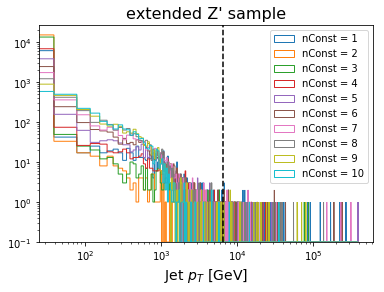

In [40]:
for i in range(1,11):
    plt.hist(flat_jet_pt[flat_jet_nConst==i],
             bins=int(1e4),range=[0,max(flat_jet_pt)],
             histtype='step',label='nConst = {}'.format(i),log=True)
                          
ylim = plt.ylim()
plt.plot([6.5e3,6.5e3],ylim,'k--')
plt.ylim(ylim)
plt.xlabel('Jet $p_T$ [GeV]',fontsize=14)
plt.xscale('log')
plt.legend()
plt.title(physicsNames[physicsSample], fontsize=16)
plt.savefig('{}/jet_pT_nConst.pdf'.format(figDir))
plt.show()

Ok, it's interesting to me that this pops up for jets with more than 1 or 2 tracks, but maybe this makes sense b/c we're more likely to have fake tracks in dense enviornments?

**Next:** Plot the jet $p_T$ of the leading jet in the event.

In [41]:
lead_jet_pt = np.array([pts[0]*0.001 for pts in myTree.array(b'jet_pt') if len(pts) > 0])
lead_jet_pdg = np.array([pdgs[0] for pdgs in myTree.array(b'jet_LabDr_HadF') if len(pdgs) > 0])

In [42]:
for pdg,flav in zip([0,4,5],['l','c','b']):
    plt.hist(lead_jet_pt[lead_jet_pdg==pdg],
             bins=int(1e4),range=[0,max(lead_jet_pt)],
             histtype='step',label=flav+'-jets',log=True)
                          
ylim = plt.ylim()
plt.plot([6.5e3,6.5e3],ylim,'k--')
plt.ylim(ylim)
plt.xlabel('Leading jet $p_T$ [GeV]',fontsize=14)
plt.xscale('log')
plt.legend()
plt.title(physicsNames[physicsSample], fontsize=16)
plt.savefig('{}/lead_jet_pT.pdf'.format(figDir))
plt.show()

Ok, so I think the message of ths pot is tat ther are jets with this very high $p_T$, but it dies off dramatically as we increase the jet $p_T$ (it's important to note that both the x and y-axes are logarithmic), so I don't think it's necessary to put an upper limit cut on the track jet $p_T$.

## Cutflow

**Goal:** We want to see how each of these cuts impact our sample, so let's make a cutflow!

What will be fun is looking into the VR track jet overlap removal cut, since it involves a double loop over the jets, and is a new cut for us.


In [43]:
physicsSample

'Zprime_5TeV'

In [44]:
jet_vars = ["jet_LabDr_HadF","jet_pt_orig","jet_eta_orig","jet_phi_orig","jet_m",
            "jet_aliveAfterOR","jet_aliveAfterORmu","jet_nConst",
            "jet_JVT","jet_pt","jet_eta","jet_phi","jet_dRminToB","jet_dRminToC"]

if 'hybrid' not in physicsSample:
    jet_vars += ["jet_bH_pt"]

jet_arr = myTree.arrays(jet_vars)
trk_arr = myTree.arrays(["jet_trk_ip3d_grade"])

In [45]:
# JVT is not defined for track jets, so I'm not applying this cut
jet_arr[b'jet_JVT']

<JaggedArray [[nan nan nan nan nan] [nan nan nan ... nan nan nan] [nan nan nan ... nan nan nan] ... [nan nan nan ... nan nan nan] [nan nan nan ... nan nan nan] [nan nan nan ... nan nan nan]] at 0x7f9a633a8748>

In [46]:
keys = ['all','pt','eta','nTrk','overlapVR','overlapElectron','overlapMuon']
xlabel = ['all jets', '$p_T$ > 10 GeV', '$|\eta|$ < 2.5',
          '$n_{trks}^{VR}$ > 1', 'VR trk jet OR',
          'electron OR','muon OR']

In [47]:
cutflow = { k: 0 for k in keys }

In [48]:
cut_eta = 2.5
cut_nConst = 2
cut_JVT = -1
mus = myTree.array(b'avgmu')

## Event Loop
print('n_events',len(mus))

#for ievt in range(n_events):
for ievt,mu in enumerate(mus):

    # Jet loop
    n_jets = len(jet_arr[b"jet_pt"][ievt])
    cutflow['all'] += n_jets
    
    # Implementation: Make a mask over the jet for each event which 
    # I can then sum over to find the jets passing the selection so far
    mask = np.ones(n_jets).astype(bool)
    
    # pt
    mask[jet_arr[b'jet_pt_orig'][ievt] < cut_pT] = False
    cutflow['pt'] += np.sum(mask)
    
    # eta
    mask[jet_arr[b'jet_eta_orig'][ievt] > cut_eta] = False
    cutflow['eta'] += np.sum(mask)
    
    # ntrk
    mask[jet_arr[b'jet_nConst'][ievt] < cut_nConst] = False
    cutflow['nTrk'] += np.sum(mask)
    
    # Assert that the jets are orderded in pt, since this is something that
    # we're assuming in the logic of the next code block
    assert (jet_arr[b'jet_pt_orig'][ievt][:-1] - jet_arr[b'jet_pt_orig'][ievt][1:] > 0).all()
    
    # VR overlap removal
    for i, pt_i, eta_i, phi_i in zip(np.arange(n_jets)[mask], 
                                     jet_arr[b'jet_pt_orig'][ievt][mask], 
                                     jet_arr[b'jet_eta_orig'][ievt][mask],
                                     jet_arr[b'jet_phi_orig'][ievt][mask]):
        
        # Get the mask for the other jets in the evt that have also 
        # passed the pt and nTrks cuts
        not_i = np.ones(n_jets).astype(bool)
        not_i[i] = False
        not_i[jet_arr[b'jet_pt_orig'][ievt] < 5000] = False
        not_i[jet_arr[b'jet_nConst'][ievt] < cut_nConst] = False
        
        # Find the min radius
        Ri = VR(pt_i / 1000)
        minJetRs = np.array(VR(jet_arr[b'jet_pt_orig'][ievt][not_i] / 1000))
        minJetRs[Ri < minJetRs] = Ri
        
        dr_jets = np.array(getdR(eta_i,phi_i,
                           jet_arr[b'jet_eta_orig'][ievt][not_i],
                           jet_arr[b'jet_phi_orig'][ievt][not_i]))
                
        if np.sum(dr_jets < minJetRs): mask[i] = False
        
    cutflow['overlapVR'] += np.sum(mask)

    # electron overlap removal
    mask *= jet_arr[b'jet_aliveAfterOR'][ievt].astype(bool)
    cutflow['overlapElectron'] += np.sum(mask)  
    
    # muon overlap removal
    mask *= jet_arr[b'jet_aliveAfterORmu'][ievt].astype(bool)
    cutflow['overlapMuon'] += np.sum(mask)  
    


n_events 5000


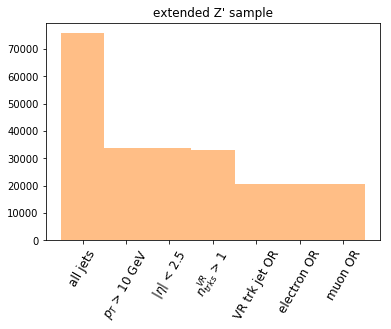

In [49]:
colors = {'ttbar' : 'C2',
          'Zprime_1.5TeV' : 'C0',
          'Zprime_5TeV' : 'C1',
          'hybrid_1.5TeV' : 'C4'}

x = np.arange(len(keys))
y = [cutflow[k] for k in keys]
plt.bar(x,y,width=1,alpha=0.5,color=colors[physicsSample])
plt.xticks(x,xlabel,rotation=60,fontsize=12)
plt.title(physicsNames[physicsSample])

plt.savefig('{}/cutflow.pdf'.format(figDir),bbox_inches='tight')
plt.show()

**Note:**
- I won't ever have track jets failing this $|\eta|$ cut, because the tracks for defining the jets have already been selected such that $|\eta| < 2.5$, according to [p5 of PERF-2017-04-001](https://cds.cern.ch/record/2661823/files/PERF-2017-04-001.pdf?).

### Flavor fractions

Another metric I can use to *check* the hybrid sample definition is to look at the flavor compositions.

In [50]:
import pandas as pd
frac = pd.DataFrame(0,index=['l','c','b'],columns=['Flavor fraction'])

### PFlow vs. VR Track Jet $p_T$ comparison

Ok... so I thought that since track jets use information about the charged clusters in the event, the $p_T$ should be about 2/3 of the $p_T$ of the calo jet. However, when just comparing the distributions, it seemed that the $p_T$ of the VR track jet was quite a bit lower, and suggests that we might want a different scheme for defining the hybrid sample.

To verify this, Francesco suggested that I look at the correlation between the PFlow and VR $p_T$ for individual jets.

**How should I define the match?**
- Use all of the selected VR and pflow jets in each event
- In the advent of two VR track jets matching to the same pflow jet, keep the VR track jet that has the higher $p_T$.

In [51]:
if 'hybrid' not in physicsSample:
    
    pflows = {
        'ttbar' : 'user.bdong.410470.ttbar_hdamp258p75_nonallhad.mc16d_newDerivation_noRetag_Akt4EMPf/user.bdong.16276417.Akt4EMPf._000002.root',
        'Zprime_1.5TeV' : 'user.bdong.mc16_13TeV.427080.flatpT_Zprime.mc16d_newDerivation_noRetag_rerun_Akt4EMPf/user.bdong.16288899.Akt4EMPf._000002.root',
        'Zprime_5TeV'   : 'user.bdong.mc16_13TeV.427081.flatpT_Zprime_Extended.mc16d_newDerivation_noRetag_Akt4EMPf/user.bdong.16288071.Akt4EMPf._000001.root'
        }

    fname = fDir + pflows[physicsSample]
    pflowTree = uproot.open(fname)["bTag_AntiKt4EMPFlowJets"]

Loop through all of the events in the jet, keeping track of the good and VR and PFlow jets.

In [52]:
jet_vars = ["jet_LabDr_HadF","jet_pt_orig","jet_eta_orig","jet_phi_orig","jet_m",
            "jet_aliveAfterOR","jet_aliveAfterORmu","jet_nConst",
            "jet_JVT","jet_pt","jet_eta"]

if physicsSample == 'hybrid_1.5TeV':
    jet_vars += ['']

pf_jet_arr = pflowTree.arrays(jet_vars)
pf_trk_arr = pflowTree.arrays(['jet_trk_ip3d_grade'])

pf_cut_JVT = 0.2
pf_cut_pT = 20000
pf_cut_nConst = -1

In [53]:
# Check that the pflow and VR distributions have the same shape
assert len(jet_arr[b'jet_pt']) == len(pf_jet_arr[b'jet_pt'])
n_events = len(jet_arr[b'jet_pt'])

In [54]:
pf_pts  = []
vr_pts  = []
# vr_dRminToBs  = []
# vr_dRminToCs  = []
vr_pdgs = []

vr_pts_2lead  = []
vr_dRminToBs_2lead  = []
vr_dRminToCs_2lead  = []
vr_pdgs_2lead = []

npfs = []
nvrs = []
nvrs_150 = []
nvrs_250 = []

# The R for the matching
R = 0.3

for ievt in range(n_events):
    
    npf_jets = len(pf_jet_arr[b"jet_pt"][ievt])
    pf_mask = np.array([passJet(pf_jet_arr, pf_trk_arr, ievt, ijet, pf_cut_pT, pf_cut_JVT, pf_cut_nConst) \
                        for ijet in range(npf_jets)])
    npf_selected = pf_mask.sum()
    
    # VR
    nvr_jets = len(jet_arr[b"jet_pt"][ievt])
    vr_mask = np.array([passJet(jet_arr, trk_arr, ievt, ijet, cut_pT, cut_JVT, cut_nConst) \
                        for ijet in range(nvr_jets)])
    nvr_selected = vr_mask.sum()
    
    if npf_selected == 0 or nvr_selected == 0:
        continue
    
    # Form a matrix of the dRs between 
    D = np.zeros((nvr_selected,npf_selected))
    
    for i, eta_i,phi_i in zip(range(npf_selected),jet_arr[b'jet_eta'][ievt][vr_mask],
                              jet_arr[b'jet_phi'][ievt][vr_mask]):
        
        D[i,:] = getdR(eta_i, phi_i,pf_jet_arr[b'jet_eta_orig'][ievt][pf_mask],
                       pf_jet_arr[b'jet_phi_orig'][ievt][pf_mask])
    
    dr_match = np.min(D,axis=1)
    idx = np.argmin(D,axis=1)
    
    # This matched index tells us which vr jet each pflow jet matches to
    matched_idx = idx[dr_match < R]
    sel_vr_idx = []
 
    # If there are multiple VR track jets matching to the same PFlow jet,
    # choose the track jet with the larger pt
    uni_idx, uni_cts = np.unique(matched_idx,return_counts=True)
    for i_pf, unique_cts in zip(uni_idx, uni_cts):
            
        # Get the indices for the vr track jets that have been matched to this pflow jet 
        ivrs = [i for i,match_pf in enumerate(matched_idx) if match_pf==i_pf] 
        sel_vr_idx.append(ivrs[0])
        
        if unique_cts != 1: 
            # The first track jet in the list will have the larger pt
            matched_idx = [v for i,v in enumerate(matched_idx) if i not in ivrs[1:]]
            
    # Append some stuff to a list so that we'll be able to load it in later!
    vr_pts.append(jet_arr[b'jet_pt'][ievt][vr_mask][sel_vr_idx])
    pf_pts.append(pf_jet_arr[b'jet_pt'][ievt][pf_mask][matched_idx])
    
#     vr_dRminToBs.append(jet_arr[b'jet_dRminToB'][ievt][vr_mask][sel_vr_idx])
#     vr_dRminToCs.append(jet_arr[b'jet_dRminToC'][ievt][vr_mask][sel_vr_idx])
    vr_pdgs.append(jet_arr[b'jet_LabDr_HadF'][ievt][vr_mask][sel_vr_idx])
        
    nvrs.append(jet_arr[b'jet_pt'][ievt][vr_mask].shape[0])
    
    # And - to see the impact of the hybrid cut, look at this w/r.t.
    # a hybrid definition with a 150 GeV and 250 GeV jet pT cut.     
    mask_150 = vr_mask.copy()
    
    # Eliminate b-jets w/ bhadron pT cut < 250 GeV (same for both versions of the hybrid)
    bH_pts = np.array([bHs[0] for bHs in jet_arr[b'jet_bH_pt'][ievt]])
    abs_pdgs = np.abs(jet_arr[b'jet_LabDr_HadF'][ievt])
    low_pT_bs = (abs_pdgs == 5) & (bH_pts < 250e3)
    mask_150[low_pT_bs] = False
    mask_150[(abs_pdgs != 5) & (jet_arr[b'jet_pt'][ievt] < 150e3)] = False
    nvrs_150.append(jet_arr[b'jet_pt'][ievt][mask_150].shape[0])
    
    mask_250 = vr_mask.copy()
    mask_250[low_pT_bs] = False
    mask_250[(abs_pdgs != 5) & (jet_arr[b'jet_pt'][ievt] < 250e3)] = False
    nvrs_250.append(jet_arr[b'jet_pt'][ievt][mask_250].shape[0])
    
    npfs.append(pf_jet_arr[b'jet_pt'][ievt][pf_mask].shape[0])
    
    vr_pts_2lead.append(jet_arr[b'jet_pt'][ievt][vr_mask][:2])
    vr_dRminToBs_2lead.append(jet_arr[b'jet_dRminToB'][ievt][vr_mask][:2])
    vr_dRminToCs_2lead.append(jet_arr[b'jet_dRminToC'][ievt][vr_mask][:2])
    vr_pdgs_2lead.append(jet_arr[b'jet_LabDr_HadF'][ievt][vr_mask][:2])
    

vr_pts = np.concatenate(vr_pts,axis=0) 
pf_pts = np.concatenate(pf_pts,axis=0)
vr_pdgs = np.concatenate(vr_pdgs,axis=0) 

vr_pts_2lead  = np.concatenate(vr_pts_2lead,axis=0) 
vr_dRminToBs_2lead = np.concatenate(vr_dRminToBs_2lead,axis=0)
vr_dRminToCs_2lead = np.concatenate(vr_dRminToCs_2lead,axis=0)
vr_pdgs_2lead = np.concatenate(vr_pdgs_2lead,axis=0) 

# Scale from MeV -> GeV
vr_pts /= 1000
pf_pts /= 1000

vr_pts_2lead /= 1000

**Working hypothesis**

If about 2/3 of the jet's energy came from it's charged constituents, then we would expect

$$p_T^{pflow} = \frac{2}{3} \cdot p_T^{VR}$$

In a lot of my intuition plots, it seemed like the track jet $p_T$ was quite a bit lower than I was expecting, so I think I need to fit the line to see exactly what this correlation is.


In [55]:
from scipy.stats import linregress

mask = (pf_pts < ptmax[physicsSample]) & (vr_pts < ptmax[physicsSample])

slope, intercept, r_value, p_value, std_err = linregress(pf_pts[mask],vr_pts[mask])
text = "Least Squares fit: y = {:.2} x + {:.1f}".format(slope,intercept)
text += "\nCorrelation Coefficient: R ={:.2}".format(r_value)

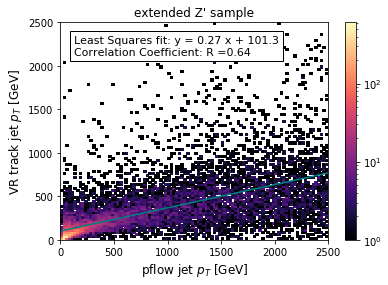

In [56]:
plt.hist2d(pf_pts,vr_pts,100, cmap="magma",norm=LogNorm(),
           range=((0,ptmax[physicsSample]),(0,ptmax[physicsSample])))

x = np.linspace(0,ptmax[physicsSample])
y = slope * x + intercept
plt.plot(x,y,'teal')


plt.text(.05*ptmax[physicsSample],.85*ptmax[physicsSample],text,
         fontsize=11,bbox=dict(facecolor='white', alpha=1))

plt.colorbar()
plt.xlabel('pflow jet $p_T$ [GeV]',fontsize=12)
plt.ylabel('VR track jet $p_T$ [GeV]',fontsize=12)
plt.title(physicsNames[physicsSample])

plt.savefig('{}/PFlow_cf/jet_pt_2d_scatter.pdf'.format(figDir),bbox_inches='tight')

plt.show()

Ok, since this is pretty close to what I was expecting, this might mean that our $p_T$ cut is just letting in a lot of crap jets, so I shouldn't train on them?

**Question 1:** What happens if I restrict the fit range from 150 GeV for VR and 200 GeV for PFlow?

In [57]:
if physicsSample == 'ttbar':
    max_pf = 200
    max_vr = 150
else:
    max_pf = 1000
    max_vr = 600
    
mask2 = (pf_pts < max_pf) & (vr_pts < max_vr)

slope, intercept, r_value, p_value, std_err = linregress(pf_pts[mask2],vr_pts[mask2])
text2 = "Least Squares fit: y = {:.2} x + {:.1f}".format(slope,intercept)
text2 += "\nCorrelation Coefficient: R ={:.2}".format(r_value)

In [58]:
plt.hist2d(pf_pts,vr_pts,100, cmap="magma",norm=LogNorm(),
           range=((0,ptmax[physicsSample]),(0,ptmax[physicsSample])))

plt.text(.05*ptmax[physicsSample],.85*ptmax[physicsSample],text2,
         fontsize=11,bbox=dict(facecolor='white', alpha=1))

# Plot some dashed lines to show the region in which we did the fit
plt.plot([max_pf]*2,[0,max_vr],linestyle='--',color='teal')
plt.plot([0,max_pf],[max_vr]*2,linestyle='--',color='teal')

plt.colorbar()
plt.xlabel('pflow jet $p_T$ [GeV]',fontsize=12)
plt.ylabel('VR track jet $p_T$ [GeV]',fontsize=12)
plt.title(physicsNames[physicsSample])

plt.savefig('{}/PFlow_cf/jet_pt_2d_scatter_restrictedFit.pdf'.format(figDir),bbox_inches='tight')

plt.show()

Ok, but also, this is only *part* of the story. I also want to look at how the the b-hadron $p_T$ is correlated with the track jet $p_T$. Recall, the b-hadron carries about 70% of the b-quark energy, but it might be more than this for the track jet $p_T$.

*But I think this is less pressing right now, I'll look into this later.*

In [59]:
# Load in the 

### Comparison of the $p_T$ distributions only taking the leading two jets in the event

In [60]:
ptmax['ttbar']

300

In [61]:
nBins = 50
myRange = [0,ptmax[physicsSample] if physicsSample =='ttbar' else 750]

for pdg,flav,color in zip([0,4,5],['l','c','b'],['C0','C1','C2']):
    
    plt.hist(vr_pts[vr_pdgs==pdg],
             bins=nBins,range=myRange, linestyle='--',color=color,
             histtype='step',label=flav+'-jets: all',log=True)
    
    plt.hist(vr_pts_2lead[vr_pdgs_2lead==pdg],
             bins=nBins,range=myRange,color=color,
             histtype='step',label=flav+'-jets: 2 leading',log=True)

plt.xlabel('Jet $p_T$ [GeV]',fontsize=14)
plt.legend()
plt.title(physicsNames[physicsSample]+" after cuts")
plt.savefig('{}/jet_pT_2lead.pdf'.format(figDir))
plt.show()

Ok, I think this is pretty interesting. The cut requing that I take the two leading jets is mostly eliminating l-jets, consistent with what everybody was saying that we want this cut to eliminate ISR.

Also, it doesn't look like this would make a difference if we have the cut for the hybrid jet $p_T$ at 250 GeV, but if we move it to 125 GeV, it will make a difference.


### Comparison of the jet multiplicity distributions for VR and PFlow

In [62]:
plt.hist(npfs,bins=16,range=(-0.5,15.5), histtype='step',color='C0',label='PFlow')
plt.hist(nvrs,bins=16,range=(-0.5,15.5), histtype='step',color='C3',label='VR')

plt.xlabel('# of good jets / event',fontsize=12)
plt.title(physicsNames[physicsSample] + ' after cuts')
plt.legend(fontsize=12)
plt.savefig('{}/PFlow_cf/nJets.pdf'.format(figDir))
plt.show()

### Jet multiplicity distributions for the Z' composition in the hybrid

In [63]:
plt.hist(nvrs,bins=16,range=(-0.5,15.5), label='VR',
         histtype='step',color='C0',linewidth=1.5)
plt.hist(nvrs_250,bins=16,range=(-0.5,15.5), label='VR: 250 GeV cut',
         histtype='step',color='C4',linewidth=1.5)
plt.hist(nvrs_150,bins=16,range=(-0.5,15.5), label='VR: 150 GeV cut',
         histtype='step',color='C1',linewidth=1.5)

plt.xlabel('# of good jets / event',fontsize=12)
plt.title(physicsNames[physicsSample] + ' after cuts')
plt.legend(fontsize=12)
plt.savefig('{}/nJets_varyHybridCuts.pdf'.format(figDir))
plt.show()

### Investigation of the opening angle between the $b$-jet and the B-hadron

(I could also look at the opening angle between the $c$-jet and the D-hadron)

In [64]:
pdg == 5
plt.hist2d(vr_pts_2lead[vr_pdgs_2lead==pdg],vr_dRminToBs_2lead[vr_pdgs_2lead==pdg],
           100,((0,2000),(0,0.1)),cmap="Greens")#,norm=LogNorm())

xlim = plt.xlim()
plt.plot(xlim,[0.02]*2,'k--')

plt.text(0.7*xlim[1],0.09,"2 leading jets")

plt.xlabel('$b$-jet $p_T$ [GeV]',fontsize=14)
plt.ylabel('$\Delta R$(jet,B-hadron)',fontsize=14)
plt.colorbar()
plt.title(physicsNames[physicsSample]+" after cuts")
plt.savefig('{}/dRminToB_vs_jpt.pdf'.format(figDir))
plt.show()

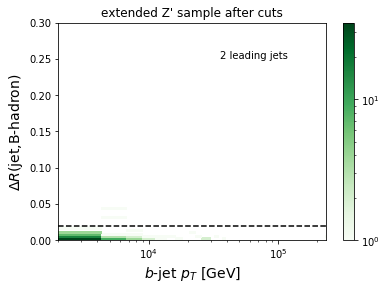

In [65]:
pdg == 5
plt.hist2d(vr_pts_2lead[vr_pdgs_2lead==pdg],vr_dRminToBs_2lead[vr_pdgs_2lead==pdg],
           100,((2000,np.max(vr_pts_2lead[vr_pdgs_2lead==pdg])),(0,0.3)),cmap="Greens",norm=LogNorm())

xlim = plt.xlim()
plt.plot(xlim,[0.02]*2,'k--')

plt.text(0.15*xlim[1],0.25,"2 leading jets")

plt.xscale('log')
#plt.yscale('log')

plt.xlabel('$b$-jet $p_T$ [GeV]',fontsize=14)
plt.ylabel('$\Delta R$(jet,B-hadron)',fontsize=14)
plt.colorbar()
plt.title(physicsNames[physicsSample]+" after cuts")
plt.savefig('{}/dRminToB_vs_jpt_logY.pdf'.format(figDir))
plt.show()

**Conclusion:** I don't think these mis-measured tracks are messing up the jet-axis that much... this is good, right?

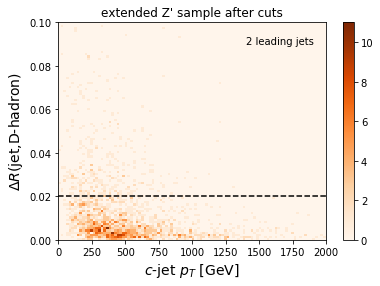

In [66]:
pdg == 4
plt.hist2d(vr_pts_2lead[vr_pdgs_2lead==pdg],vr_dRminToCs_2lead[vr_pdgs_2lead==pdg],
           100,((0,2000),(0,0.1)),cmap="Oranges")#,norm=LogNorm())

xlim = plt.xlim()
plt.plot(xlim,[0.02]*2,'k--')

plt.text(0.7*xlim[1],0.09,"2 leading jets")

plt.xlabel('$c$-jet $p_T$ [GeV]',fontsize=14)
plt.ylabel('$\Delta R$(jet,D-hadron)',fontsize=14)
plt.colorbar()
plt.title(physicsNames[physicsSample]+" after cuts")
plt.savefig('{}/dRminToC_vs_jpt.pdf'.format(figDir))
plt.show()

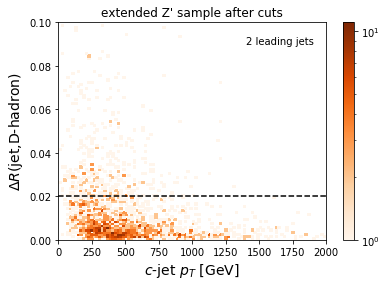

In [67]:
pdg == 4
plt.hist2d(vr_pts_2lead[vr_pdgs_2lead==pdg],vr_dRminToCs_2lead[vr_pdgs_2lead==pdg],
           100,((0,2000),(0,0.1)),cmap="Oranges",norm=LogNorm())

xlim = plt.xlim()
plt.plot(xlim,[0.02]*2,'k--')

plt.text(0.7*xlim[1],0.09,"2 leading jets")

plt.xlabel('$c$-jet $p_T$ [GeV]',fontsize=14)
plt.ylabel('$\Delta R$(jet,D-hadron)',fontsize=14)
plt.colorbar()
plt.title(physicsNames[physicsSample]+" after cuts")
plt.savefig('{}/dRminToC_vs_jpt_logY.pdf'.format(figDir))
plt.show()